###  Cell A — Imports, config, run tag

In [1]:
# === Cell A — Imports, CONFIG, run tag ===
from pathlib import Path
import sys, yaml, json
from datetime import datetime

# --- project paths ---
root = Path("..").resolve()
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
if str(root / "src") not in sys.path:
    sys.path.insert(0, str(root / "src"))

# --- load global YAML config ---
cfg_path = root / "configs" / "wlasl100.yaml"
CFG = yaml.safe_load(open(cfg_path, "r"))

# === ROI manifest for top-104 balanced classes ===
# CHANGE THIS if your cleaned manifest has a different name
DATA_MANIFEST = root / "data" / "wlasl_preprocessed" / "manifest_nslt2000_roi_top104_balanced_clean.csv"

assert DATA_MANIFEST.exists(), f"Missing manifest: {DATA_MANIFEST}"

# --- base CONFIG (you can tweak) ---
CONFIG = {
    # data
    "clip_len":        32,        # number of frames per clip
    "frame_stride":    2,
    "batch_size":      8,
    "num_workers":     4,
    "use_weighted_sampler": True, # balance classes via sampler

    # model
    "backbone":        "r3d18_k400",  # ["c3dlite_gn", "r3d18_k400", "r2plus1d_k400"]
    "dropout":         0.2,
    "label_smoothing": 0.0,       # 0.0..0.2
    "normalize":       "kinetics",# ["kinetics","none"]
    "amp":             True,      # mixed precision
    "compile":         True,      # torch.compile if available
    "seed":            CFG["wlasl"]["split_seed"],

    # optimization
    "epochs":          25,
    "lr":              1e-4,      # lower LR for pretrained
    "weight_decay":    1e-5,
    "grad_accum":      1,
    "warmup_epochs":   2,
    "cosine_eta_min":  1e-5,

    # staged fine-tuning (optional, wired in for r3d18_k400)
    "freeze_backbone": True,      # stage 1: train head only
    "unfreeze_at_epoch": 5,       # stage 2: unfreeze later
    "unfreeze_scope":  "layer4",  # deepest block

    # resume / checkpoints
    "resume":          "",        # e.g. "checkpoints/best_roi_r3d18.pt"
    "save_every_epoch": False,
}

# derived paths
CKPT_DIR = root / CFG["paths"]["checkpoints_dir"]
LOG_DIR  = root / CFG["paths"]["logs_dir"]
CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

# record this run config (nice for reproducibility)
stamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
run_tag = f"roi_top104_{CONFIG['backbone']}_T{CONFIG['clip_len']}_B{CONFIG['batch_size']}_{stamp}"
with open(LOG_DIR / f"{run_tag}.config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

print("Run tag:", run_tag)
print("Manifest:", DATA_MANIFEST)


Run tag: roi_top104_r3d18_k400_T32_B8_20251118T014935Z
Manifest: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/manifest_nslt2000_roi_top104_balanced_clean.csv


### Cell B — Dataset, Kinetics normalization, DataLoader

In [2]:
# === Cell B — Dataset, normalization, loaders ===
import torch, torch.nn.functional as F, numpy as np, pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler

from src.utils.seed import seed_everything
from src.data.wlasl_ds import WLASLDataset
import src.data.wlasl_ds as wds_mod

# ---------- reproducibility ----------
seed_everything(CONFIG["seed"])

# ---------- Kinetics-style normalization ----------
def kinetics_normalize(x):
    # x: [T,C,H,W], float32 in [0,1]
    mean = torch.tensor((0.432, 0.394, 0.376), dtype=x.dtype, device=x.device)[None,:,None,None]
    std  = torch.tensor((0.228, 0.221, 0.223), dtype=x.dtype, device=x.device)[None,:,None,None]
    return (x - mean) / std

if CONFIG["normalize"] == "kinetics":
    wds_mod._normalize = kinetics_normalize
elif CONFIG["normalize"] == "none":
    wds_mod._normalize = lambda x: x

# ---------- load ROI manifest ----------
m = pd.read_csv(DATA_MANIFEST)
assert {"path","label_new","split"}.issubset(m.columns), m.columns

# Use label_new as our contiguous label
m = m.copy()
m["label"] = m["label_new"].astype(int)
num_classes = m["label"].nunique()
print("num_classes:", num_classes)

clip_len = CONFIG["clip_len"]
stride   = CONFIG["frame_stride"]
bs       = CONFIG["batch_size"]
nw       = CONFIG["num_workers"]

train_df = m[m.split == "train"].reset_index(drop=True)
val_df   = m[m.split == "val"].reset_index(drop=True)
test_df  = m[m.split == "test"].reset_index(drop=True)

train_ds = WLASLDataset(train_df, clip_len=clip_len, stride=stride, train=True)
val_ds   = WLASLDataset(val_df,   clip_len=clip_len, stride=stride, train=False)
test_ds  = WLASLDataset(test_df,  clip_len=clip_len, stride=stride, train=False)

if CONFIG["use_weighted_sampler"]:
    counts  = train_df["label"].value_counts().to_dict()
    weights = train_df["label"].map(lambda y: 1.0 / counts[y]).values.astype(np.float32)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=bs, sampler=sampler,
                              num_workers=nw, pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,
                              num_workers=nw, pin_memory=True)

val_loader  = DataLoader(val_ds,  batch_size=bs, shuffle=False,
                         num_workers=nw, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False,
                         num_workers=nw, pin_memory=True)

print(f"Splits | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)} | classes={num_classes}")


num_classes: 104
Splits | train=831 val=192 test=136 | classes=104


#### Cell C — Models (C3Dlite and R3D18 K400, extendable to R(2+1)D later)

In [3]:
# === Cell C — Model factory (C3Dlite GN, R3D18 K400, extensible) ===
import torch.nn as nn
from torchvision.models.video import r3d_18, R3D_18_Weights

# Small 3D GN CNN (from your old code)
class C3DliteGN(nn.Module):
    def __init__(self, num_classes=100, drop=0.5):
        super().__init__()
        def gn(c): return nn.GroupNorm(num_groups=8, num_channels=c)
        def block(cin, cout, pool_t=2):
            return nn.Sequential(
                nn.Conv3d(cin, cout, 3, padding=1, bias=False),
                gn(cout), nn.ReLU(inplace=True),
                nn.MaxPool3d(kernel_size=(pool_t,2,2), stride=(pool_t,2,2)),
            )
        self.stem = nn.Sequential(
            nn.Conv3d(3, 32, 3, padding=1, bias=False),
            gn(32), nn.ReLU(inplace=True),
        )
        self.b1 = block(32,  64)
        self.b2 = block(64, 128)
        self.b3 = block(128, 256)
        self.b4 = block(256, 256)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Dropout(drop),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):             # x [B,T,C,H,W]
        x = x.permute(0,2,1,3,4).contiguous()   # [B,C,T,H,W]
        x = self.stem(x)
        x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
        return self.head(x)

class R3D18WithPermute(nn.Module):
    """Wrap r3d_18 to accept [B, T, C, H, W] and permute internally."""
    def __init__(self, num_classes, pretrained=True, dropout=0.2):
        super().__init__()
        weights = R3D_18_Weights.KINETICS400_V1 if pretrained else None
        self.backbone = r3d_18(weights=weights)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, num_classes)

    def forward(self, x):  # x: [B, T, C, H, W]
        x = x.permute(0, 2, 1, 3, 4).contiguous()  # [B,C,T,H,W]
        return self.backbone(x)

def make_model(backbone, num_classes, drop):
    if backbone == "r3d18_k400":
        return R3D18WithPermute(num_classes=num_classes, pretrained=True, dropout=drop)
    elif backbone == "c3dlite_gn":
        return C3DliteGN(num_classes=num_classes, drop=drop)
    # extend here later for r2plus1d_k400, mc3_k400, etc.
    raise ValueError(f"Unknown backbone: {backbone}")

# build model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

model = make_model(CONFIG["backbone"], num_classes=num_classes, drop=CONFIG["dropout"]).to(device)

if CONFIG["compile"]:
    try:
        model = torch.compile(model)
        print("torch.compile: ON")
    except Exception as e:
        print("torch.compile skipped:", e)

print("Backbone:", CONFIG["backbone"])
print("Device:", device)


torch.compile: ON
Backbone: r3d18_k400
Device: cuda


#### Cell D — Optimizer, scheduler, scaler, optional staged unfreezing

In [4]:
# === Cell D — Optimizer, scheduler, GradScaler, staged unfreezing ===
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler

epochs   = int(CONFIG["epochs"])
lr       = float(CONFIG["lr"])
wd       = float(CONFIG["weight_decay"])
amp_on   = bool(CONFIG["amp"])
gs       = int(CONFIG["grad_accum"])
warmup   = int(CONFIG["warmup_epochs"])
eta_min  = float(CONFIG["cosine_eta_min"])

opt   = AdamW(model.parameters(), lr=lr, weight_decay=wd)
sched = CosineAnnealingLR(opt, T_max=max(1, epochs - warmup), eta_min=eta_min)
scaler = GradScaler(device.type if device.type == "cuda" else "cpu", enabled=amp_on)

best_val = -1.0
start_epoch = 0

# optional resume
resume = CONFIG.get("resume") or ""
if resume:
    from src.utils.checkpoints import load_checkpoint
    rp = root / resume
    if rp.exists():
        start_epoch, best_val = load_checkpoint(str(rp), model, opt, scaler)
        print(f"Resumed from {rp} @ epoch {start_epoch} best={best_val:.3f}")

def maybe_freeze_backbone(epoch):
    """Stage-1 freeze backbone, then unfreeze scope (e.g. layer4) after unfreeze_at_epoch."""
    if CONFIG["backbone"] != "r3d18_k400":
        return

    freeze = CONFIG.get("freeze_backbone", False)
    unfreeze_at = CONFIG.get("unfreeze_at_epoch", 0)
    scope = CONFIG.get("unfreeze_scope", "layer4")

    if not freeze:
        return

    if epoch == 0:
        # freeze all backbone parameters initially
        for name, p in model.named_parameters():
            if "backbone" in name:
                p.requires_grad = False
        # but keep final FC trainable
        for name, p in model.named_parameters():
            if "backbone.fc" in name:
                p.requires_grad = True
        print("[FT] Backbone frozen except final fc.")

    if epoch == unfreeze_at:
        # unfreeze selected scope
        for name, p in model.named_parameters():
            if f"backbone.{scope}" in name:
                p.requires_grad = True
        print(f"[FT] Unfroze backbone scope: {scope}")


#### Cell E — Epoch runner + Training loop + Checkpoints

In [5]:
# === Cell E — Train / eval loops, checkpointing ===
from src.utils.checkpoints import save_checkpoint

def top1_acc(logits, y):
    with torch.no_grad():
        return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, train=True, epoch=0):
    model.train() if train else model.eval()
    tot_loss = tot_acc = tot_n = 0.0
    opt.zero_grad(set_to_none=True)

    for step, (x, y, _) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.amp.autocast(device_type=device.type, enabled=amp_on):
            logits = model(x)
            loss = F.cross_entropy(
                logits, y,
                label_smoothing=CONFIG["label_smoothing"]
            ) / gs

        if train:
            scaler.scale(loss).backward()
            if (step + 1) % gs == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)

        with torch.no_grad():
            bs = x.size(0)
            tot_loss += (loss.item() * gs) * bs
            tot_acc  += top1_acc(logits, y) * bs
            tot_n    += bs

    if train:
        if epoch < warmup:
            # linear warmup
            warm_lr = lr * float(epoch + 1) / max(1, warmup)
            for g in opt.param_groups:
                g["lr"] = warm_lr
        else:
            sched.step()

    return tot_loss / max(1, tot_n), tot_acc / max(1, tot_n)

# ----- MAIN TRAINING LOOP -----
# record history for plotting and reporting
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(start_epoch, epochs):
    maybe_freeze_backbone(epoch)

    tr_loss, tr_acc = run_epoch(train_loader, train=True,  epoch=epoch)
    va_loss, va_acc = run_epoch(val_loader,   train=False, epoch=epoch)

    # append and persist history
    history["train_loss"].append(float(tr_loss))
    history["train_acc"].append(float(tr_acc))
    history["val_loss"].append(float(va_loss))
    history["val_acc"].append(float(va_acc))
    try:
        import json
        with open(LOG_DIR / f"{run_tag}_history.json", "w") as hf:
            json.dump(history, hf, indent=2)
    except Exception as e:
        print("Warning: failed to save history:", e)

    print(f"Epoch {epoch+1:03d}/{epochs} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": opt.state_dict(),
        "scaler_state": scaler.state_dict(),
        "best_metric": best_val,
    }
    # always save last
    save_checkpoint(state, is_best=False, ckpt_dir=str(CKPT_DIR), filename=f"{run_tag}_last.pt")

    if CONFIG["save_every_epoch"]:
        save_checkpoint(state, is_best=False, ckpt_dir=str(CKPT_DIR),
                        filename=f"{run_tag}_epoch_{epoch:04d}.pt")

    if va_acc > best_val:
        best_val = va_acc
        save_checkpoint(state, is_best=True, ckpt_dir=str(CKPT_DIR), filename=f"{run_tag}_best.pt")


[FT] Backbone frozen except final fc.
Epoch 001/25 | train loss 4.7646 acc 0.007 | val loss 4.7375 acc 0.005
Epoch 001/25 | train loss 4.7646 acc 0.007 | val loss 4.7375 acc 0.005
Epoch 002/25 | train loss 4.6808 acc 0.012 | val loss 4.6974 acc 0.016
Epoch 002/25 | train loss 4.6808 acc 0.012 | val loss 4.6974 acc 0.016
Epoch 003/25 | train loss 4.6265 acc 0.016 | val loss 4.6832 acc 0.005
Epoch 003/25 | train loss 4.6265 acc 0.016 | val loss 4.6832 acc 0.005
Epoch 004/25 | train loss 4.5736 acc 0.035 | val loss 4.6754 acc 0.010
Epoch 004/25 | train loss 4.5736 acc 0.035 | val loss 4.6754 acc 0.010
Epoch 005/25 | train loss 4.5254 acc 0.030 | val loss 4.6655 acc 0.016
[FT] Unfroze backbone scope: layer4
Epoch 005/25 | train loss 4.5254 acc 0.030 | val loss 4.6655 acc 0.016
[FT] Unfroze backbone scope: layer4
Epoch 006/25 | train loss 4.4755 acc 0.048 | val loss 4.6502 acc 0.010
Epoch 006/25 | train loss 4.4755 acc 0.048 | val loss 4.6502 acc 0.010
Epoch 007/25 | train loss 4.4548 acc 0

#### Cell F — run_epoch (with correct [B,C,T,H,W] permute)

In [6]:
# === Cell F — Metrics + epoch runner (for CNN+BiGRU) ===

def top1_acc(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_acc  = 0.0
    total_n    = 0

    opt.zero_grad(set_to_none=True)

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)  # [B,T,C,H,W]
        y = y.to(device, non_blocking=True)

        # Note: model wrappers (R3D18WithPermute, C3DliteGN) already permute internally
        # so keep input as [B,T,C,H,W] here and do NOT permute.

        with torch.amp.autocast(device_type=device.type, enabled=amp_on):
            logits = model(x)
            loss = F.cross_entropy(logits, y, label_smoothing=CONFIG.get('label_smoothing', 0.0))

        if train:
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)

        with torch.no_grad():
            acc = top1_acc(logits, y)
            bs  = x.size(0)
            total_loss += loss.item() * bs
            total_acc  += acc * bs
            total_n    += bs

    return total_loss / total_n, total_acc / total_n



#### Cell G — Training Loop

In [7]:
# === Cell G — Training Loop ===
ckpt_dir = root / "checkpoints"
ckpt_dir.mkdir(exist_ok=True)

best_val_acc = -1.0

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        save_path = ckpt_dir / "best_r2plus1d_k400_top104.pt"
        torch.save(model.state_dict(), save_path)
        print(f"  ➜ New best val acc={best_val_acc:.3f} ")


Epoch 01/25 | train loss 4.1223 acc 0.233 | val loss 4.5586 acc 0.068
  ➜ New best val acc=0.068 
Epoch 02/25 | train loss 4.1711 acc 0.208 | val loss 4.5585 acc 0.062
Epoch 02/25 | train loss 4.1711 acc 0.208 | val loss 4.5585 acc 0.062
Epoch 03/25 | train loss 4.1670 acc 0.187 | val loss 4.5571 acc 0.068
Epoch 03/25 | train loss 4.1670 acc 0.187 | val loss 4.5571 acc 0.068
Epoch 04/25 | train loss 4.1440 acc 0.225 | val loss 4.5534 acc 0.068
Epoch 04/25 | train loss 4.1440 acc 0.225 | val loss 4.5534 acc 0.068
Epoch 05/25 | train loss 4.1337 acc 0.211 | val loss 4.5543 acc 0.062
Epoch 05/25 | train loss 4.1337 acc 0.211 | val loss 4.5543 acc 0.062
Epoch 06/25 | train loss 4.1483 acc 0.221 | val loss 4.5517 acc 0.073
  ➜ New best val acc=0.073 
Epoch 06/25 | train loss 4.1483 acc 0.221 | val loss 4.5517 acc 0.073
  ➜ New best val acc=0.073 
Epoch 07/25 | train loss 4.1602 acc 0.194 | val loss 4.5561 acc 0.068
Epoch 07/25 | train loss 4.1602 acc 0.194 | val loss 4.5561 acc 0.068
Epoch 

In [8]:
ckpt_dir = root / "checkpoints"
best_path = ckpt_dir / "best_r2plus1d_k400_top104.pt"

model.load_state_dict(torch.load(best_path, map_location=device))
model.to(device)

test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"TEST — loss {test_loss:.4f} | acc {test_acc:.3f}")


TEST — loss 4.5407 | acc 0.015


Loaded history from /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/runs/roi_top104_r3d18_k400_T32_B8_20251118T014935Z_history.json


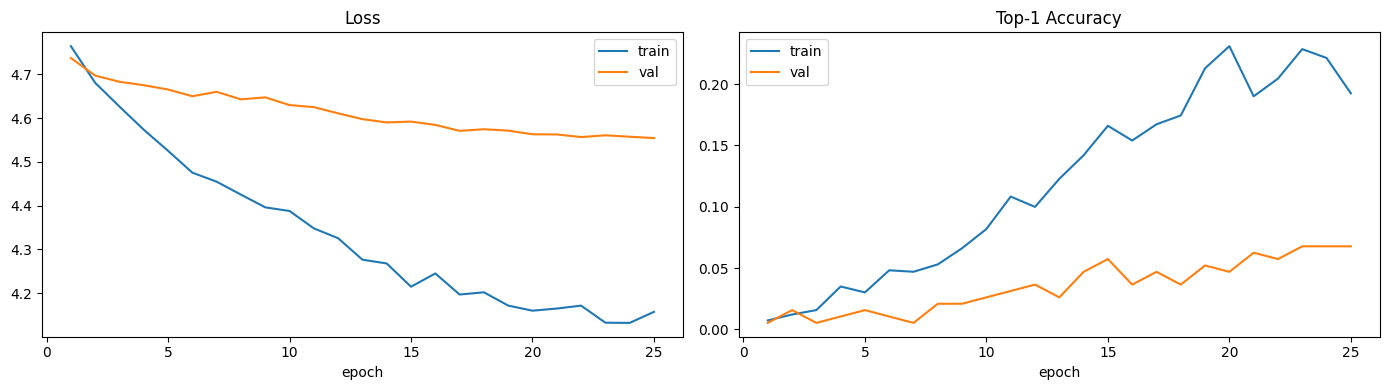

Loading best model from /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/roi_top104_r3d18_k400_T32_B8_20251118T014935Z_best.pt


Evaluating test set: 100%|██████████| 17/17 [00:03<00:00,  5.19it/s]



Test Top-1 accuracy: 0.0074 (N=136)


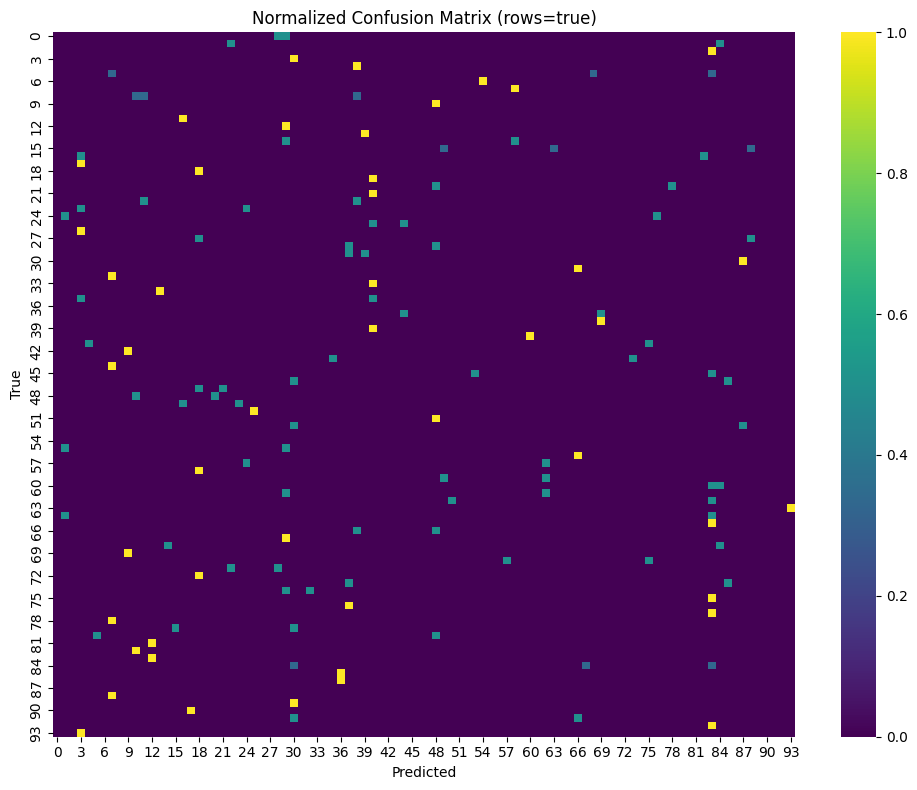

,label,gloss,accuracy,support
0,20,cheat,1.0,1
1,0,accident,0.0,2
2,3,argue,0.0,1
3,4,bad,0.0,1
4,5,balance,0.0,1
5,2,appointment,0.0,2
6,7,basketball,0.0,1
7,8,because,0.0,1
8,10,before,0.0,3
9,11,bird,0.0,1



Saved classification report (json & txt) at: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-tuned_roi_top104_r3d18_k400_T32_B8_20251118T014935Z_classification_report.json /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-tuned_roi_top104_r3d18_k400_T32_B8_20251118T014935Z_classification_report.txt

Saved test_report.json and test_report.txt to /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports


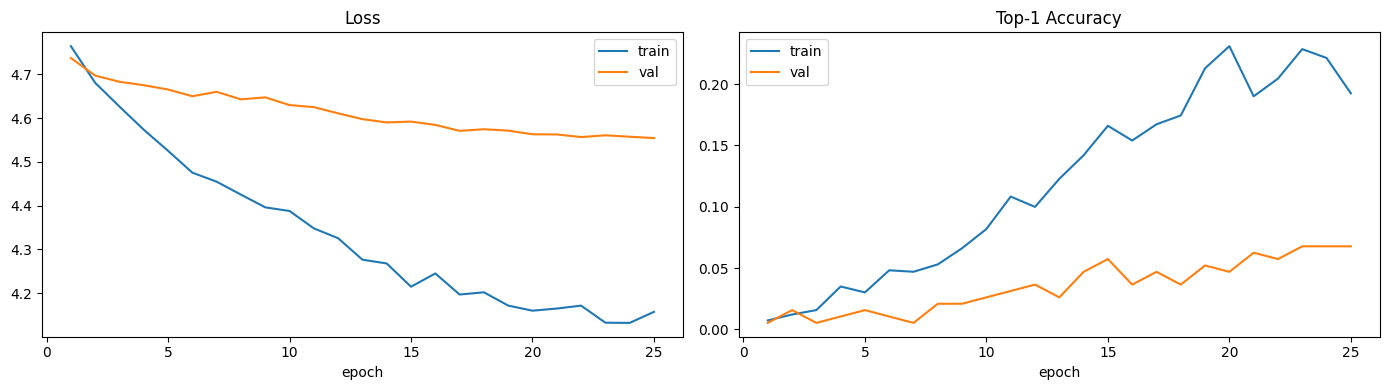

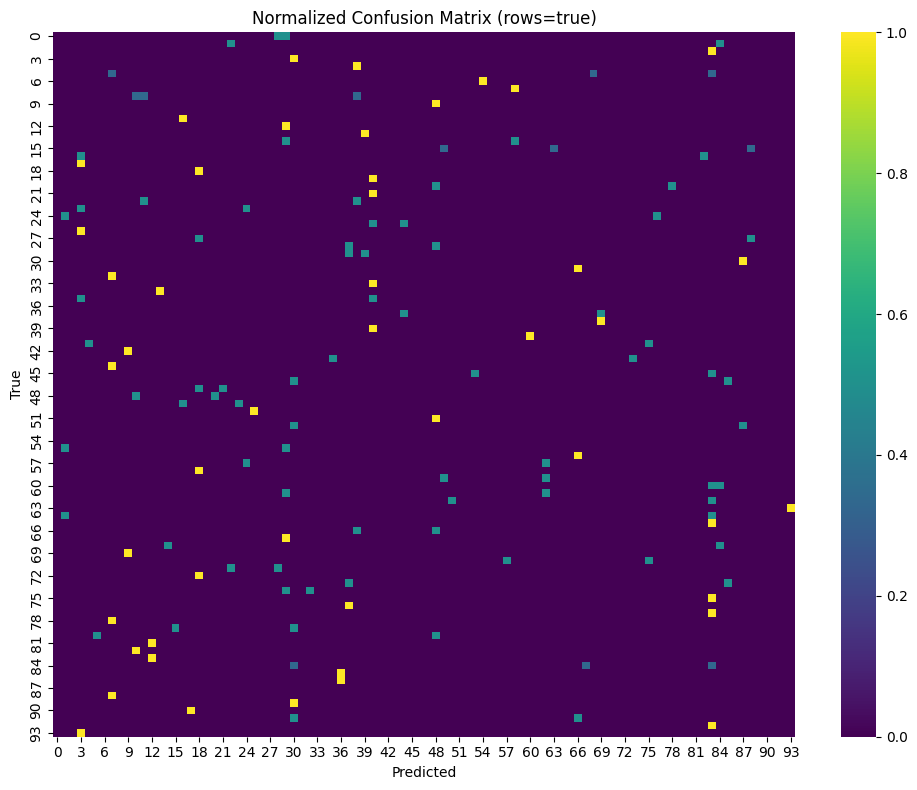

In [9]:
# === Cell H — Evaluation, Plots and Test Report ===
"""
Load training history and the best checkpoint, evaluate on the test set,
plot train/val curves, normalized confusion matrix (for labels actually present),
compute per-class accuracy and classification report. Save artifacts to `reports/`
with filenames prefixed by the notebook stem so they're unique per-notebook.
"""

import os, time, json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

# directories and prefix
ckpt_dir = CKPT_DIR if 'CKPT_DIR' in globals() else (root / 'checkpoints')
report_dir = root / "reports"
report_dir.mkdir(parents=True, exist_ok=True)
nb_stem = Path("06_train_baseline_3dCNN-r3d18_k400_kenetics-tuned.ipynb").stem
nb_prefix = str(nb_stem).replace(' ', '_')

# look for history (prefer LOG_DIR/{run_tag}_history.json)
history = None
hist_path_candidates = []
if 'LOG_DIR' in globals():
    hist_path_candidates.append(LOG_DIR / f"{run_tag}_history.json")
# also check reports dir for older naming
hist_path_candidates.append(report_dir / f"{nb_prefix}_train_history.json")
for hp in hist_path_candidates:
    try:
        if hp.exists():
            with open(hp, 'r') as f:
                history = json.load(f)
            print('Loaded history from', hp)
            break
    except Exception:
        pass

# plot curves if available
curves_path = None
if history is not None:
    epochs_ran = len(history.get('train_loss', []))
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    axs[0].plot(range(1, epochs_ran+1), history.get('train_loss', []), label='train')
    axs[0].plot(range(1, epochs_ran+1), history.get('val_loss', []), label='val')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    axs[1].plot(range(1, epochs_ran+1), history.get('train_acc', []), label='train')
    axs[1].plot(range(1, epochs_ran+1), history.get('val_acc', []), label='val')
    axs[1].set_title('Top-1 Accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()

    plt.tight_layout()
    curves_path = report_dir / f"{nb_prefix}_{run_tag}_train_val_curves.png"
    plt.savefig(str(curves_path), dpi=150)
    display(fig)
else:
    print('No training history found; skipping curve plots.')

# find best model: try a few common patterns (this notebook saves {run_tag}_best.pt in CKPT_DIR)
best_model_path = None
candidates = [
    ckpt_dir / f"{run_tag}_best.pt",
    ckpt_dir / f"{nb_prefix}_best.pt",
    ckpt_dir / f"{nb_prefix}_best_cnn_Kinetics-400s.pt",
    ckpt_dir / 'best.pt'
]
for p in candidates:
    if p.exists():
        best_model_path = p
        break

if best_model_path is None:
    print('Best model not found in', ckpt_dir)
    print('Tried:', candidates)
    print('Skipping test evaluation.')
else:
    print('Loading best model from', best_model_path)

    # Robust loading: checkpoint might be a dict with metadata and nested model state
    raw = torch.load(str(best_model_path), map_location=device)
    state_dict = None
    if isinstance(raw, dict):
        # common wrappers
        if 'model_state' in raw:
            state_dict = raw['model_state']
        elif 'model' in raw and isinstance(raw['model'], dict):
            state_dict = raw['model']
        else:
            # maybe the file is already a state_dict but stored inside a plain dict
            # try to detect by checking for conv weights keys
            # if keys look like 'epoch' and 'model_state' are the only top-level entries, handle above
            # fallback: treat raw as state_dict if keys look like parameter tensors
            maybe_keys = list(raw.keys())
            if maybe_keys and isinstance(raw[maybe_keys[0]], (torch.Tensor,)):
                state_dict = raw
            elif 'state_dict' in raw:
                state_dict = raw['state_dict']
    else:
        state_dict = raw

    if state_dict is None:
        raise RuntimeError(f'Could not locate model state_dict inside checkpoint: {best_model_path}')

    # Try direct load, then try common key-prefix fixes (module., _orig_mod.) if it fails
    def try_load(sd, strict=True):
        try:
            model.load_state_dict(sd, strict=strict)
            return True, None
        except Exception as e:
            return False, e

    ok, err = try_load(state_dict, strict=False)
    if not ok:
        print('Direct load failed (attempting to remap common prefixes):', err)
        # inspect first few keys to guess prefixes
        model_keys = list(model.state_dict().keys())
        ck_keys = list(state_dict.keys())

        def remap_keys(sd, add_prefix=None, remove_prefix=None):
            out = {}
            for k, v in sd.items():
                nk = k
                if remove_prefix and nk.startswith(remove_prefix):
                    nk = nk[len(remove_prefix):]
                if add_prefix:
                    nk = add_prefix + nk
                out[nk] = v
            return out

        attempted = []
        # case A: model keys expect '_orig_mod.' but ck keys do not
        if model_keys and not ck_keys[0].startswith('_orig_mod.') and model_keys[0].startswith('_orig_mod.'):
            cand = remap_keys(state_dict, add_prefix='_orig_mod.')
            attempted.append(('add _orig_mod.', cand))
        # case B: ck keys have '_orig_mod.' but model keys don't
        if ck_keys and ck_keys[0].startswith('_orig_mod.') and (not model_keys or not model_keys[0].startswith('_orig_mod.')):
            cand = remap_keys(state_dict, remove_prefix='_orig_mod.')
            attempted.append(('remove _orig_mod.', cand))
        # case C: missing/extra 'module.' (DataParallel)
        if model_keys and not ck_keys[0].startswith('module.') and model_keys[0].startswith('module.'):
            cand = remap_keys(state_dict, add_prefix='module.')
            attempted.append(('add module.', cand))
        if ck_keys and ck_keys[0].startswith('module.') and (not model_keys or not model_keys[0].startswith('module.')):
            cand = remap_keys(state_dict, remove_prefix='module.')
            attempted.append(('remove module.', cand))

        loaded = False
        for desc, cand in attempted:
            ok2, err2 = try_load(cand, strict=False)
            print(f'Attempt {desc}:', 'OK' if ok2 else f'Failed: {err2}')
            if ok2:
                loaded = True
                state_dict = cand
                break

        if not loaded:
            # last resort: try partial load by matching overlapping keys
            print('Attempting partial load by intersection of keys (last resort).')
            model_sd = model.state_dict()
            intersect = {k: v for k, v in state_dict.items() if k in model_sd and v.shape == model_sd[k].shape}
            if not intersect:
                raise RuntimeError('No matching parameter keys between checkpoint and model after remapping.')
            try:
                model.load_state_dict(intersect, strict=False)
                print('Partial load successful (loaded intersecting keys).')
            except Exception as e:
                raise RuntimeError('Partial load failed: ' + str(e))

    # move model to device and eval
    model.to(device)
    model.eval()

    # proceed with evaluation (state_dict variable may have been updated by remapping)

    # If you want to re-initialize optimizer or scaler states, you can load them from raw if present
    # (e.g., raw.get('optim_state'))

    y_true = []
    y_pred = []
    paths = []
    losses = []

    with torch.no_grad():
        for x, y, pth in tqdm(test_loader, desc='Evaluating test set'):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            # keep the input ordering as the model expects (many models permute internally)
            with torch.amp.autocast(device_type=device.type, enabled=amp_on):
                logits = model(x)
                loss = F.cross_entropy(logits, y, label_smoothing=CONFIG.get('label_smoothing', 0.0))
                preds = logits.argmax(1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            paths.extend(pth)
            losses.extend([float(loss.cpu().item())] * x.size(0))

    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)
    losses = np.array(losses, dtype=float)

    test_acc = float((y_true == y_pred).mean())
    print(f'Test Top-1 accuracy: {test_acc:.4f} (N={len(y_true)})')

    # mapping label->gloss if available (this notebook uses 'm' and train_df)
    label_to_name = None
    if 'm' in globals():
        # try common columns
        if 'gloss' in m.columns:
            tmp = m.groupby('label')['gloss'].first().to_dict()
            label_to_name = {int(k): str(v) for k, v in tmp.items()}
        elif 'gloss_new' in m.columns:
            tmp = m.groupby('label')['gloss_new'].first().to_dict()
            label_to_name = {int(k): str(v) for k, v in tmp.items()}
        elif 'label_new' in m.columns and 'gloss' in m.columns:
            tmp = m.groupby('label_new')['gloss'].first().to_dict()
            label_to_name = {int(k): str(v) for k, v in tmp.items()}

    # only consider labels actually present in either y_true or y_pred
    present_labels = sorted(set(np.unique(y_true)).union(set(np.unique(y_pred))))
    labels_list = [int(x) for x in present_labels]

    # names list for present labels
    if label_to_name is not None:
        names_list = [label_to_name.get(int(l), str(int(l))) for l in labels_list]
    else:
        names_list = [str(int(l)) for l in labels_list]

    # confusion matrix for present labels
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)

    fig, ax = plt.subplots(figsize=(10, 8))
    if len(labels_list) <= 50:
        sns.heatmap(cm_norm, xticklabels=names_list, yticklabels=names_list, cmap='viridis', vmin=0, vmax=1, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    else:
        sns.heatmap(cm_norm, cmap='viridis', vmin=0, vmax=1, ax=ax)
    ax.set_title('Normalized Confusion Matrix (rows=true)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.tight_layout()
    cm_path = report_dir / f"{nb_prefix}_{run_tag}_confusion_matrix_norm.png"
    plt.savefig(str(cm_path), dpi=150)
    display(fig)

    # per-class accuracy
    support = cm.sum(axis=1)
    per_class_acc = (cm.diagonal().astype('float') / (support + 1e-12))
    class_acc_df = pd.DataFrame({
        'label': labels_list,
        'gloss': names_list,
        'accuracy': per_class_acc,
        'support': support
    })
    class_acc_df = class_acc_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

    display(class_acc_df.head(20))
    per_class_csv = report_dir / f"{nb_prefix}_{run_tag}_per_class_accuracy.csv"
    class_acc_df.to_csv(str(per_class_csv), index=False)

    # classification report for present labels only (both text and JSON)
    clf_report_dict = classification_report(y_true, y_pred, labels=labels_list, target_names=names_list, zero_division=0, output_dict=True)
    clf_report_txt = classification_report(y_true, y_pred, labels=labels_list, target_names=names_list, zero_division=0)

    # save classification report as JSON and TXT
    clf_json_path = report_dir / f"{nb_prefix}_{run_tag}_classification_report.json"
    with open(str(clf_json_path), 'w') as f:
        json.dump(clf_report_dict, f, indent=2)

    clf_txt_path = report_dir / f"{nb_prefix}_{run_tag}_classification_report.txt"
    with open(str(clf_txt_path), 'w') as f:
        f.write(clf_report_txt)

    print('\nSaved classification report (json & txt) at:', clf_json_path, clf_txt_path)

    # predictions CSV
    preds_df = pd.DataFrame({'path': paths, 'y_true': y_true.tolist(), 'y_pred': y_pred.tolist()})
    preds_df['y_true_name'] = preds_df['y_true'].map(lambda x: label_to_name.get(int(x), str(int(x))) if label_to_name is not None else str(int(x)))
    preds_df['y_pred_name'] = preds_df['y_pred'].map(lambda x: label_to_name.get(int(x), str(int(x))) if label_to_name is not None else str(int(x)))
    preds_csv = report_dir / f"{nb_prefix}_{run_tag}_predictions.csv"
    preds_df.to_csv(str(preds_csv), index=False)

    # assemble summary report for downstream writing (ChatGPT-ready)
    report = {
        'created_at': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()),
        'notebook': nb_prefix,
        'model': repr(model.__class__.__name__),
        'best_model_path': str(best_model_path),
        'num_parameters': int(sum(p.numel() for p in model.parameters())),
        'num_trainable_parameters': int(sum(p.numel() for p in model.parameters() if p.requires_grad)),
        'dataset': {
            'n_train': int(len(train_df)) if 'train_df' in globals() else None,
            'n_val': int(len(val_df)) if 'val_df' in globals() else None,
            'n_test': int(len(test_df)) if 'test_df' in globals() else None,
            'num_classes_present': int(len(labels_list)),
            'num_classes_total_in_manifest': int(m['label'].nunique()) if 'm' in globals() else None
        },
        'evaluation': {
            'test_top1': float(test_acc),
            'n_samples': int(len(y_true)),
            'per_class_csv': str(per_class_csv),
            'confusion_matrix_png': str(cm_path),
            'classification_report_json': str(clf_json_path),
            'predictions_csv': str(preds_csv)
        },
        'training': {
            'epochs_ran': int(len(history.get('train_loss', []))) if history is not None else None,
            'best_val_acc': float(best_val_acc) if 'best_val_acc' in globals() else None,
            'hyperparameters': {
                'epochs': int(epochs) if 'epochs' in globals() else None,
                'lr': float(lr) if 'lr' in globals() else None,
                'weight_decay': float(wd) if 'wd' in globals() else None,
                'batch_size': int(bs) if 'bs' in globals() else None,
                'amp_on': bool(amp_on) if 'amp_on' in globals() else None,
                'clip_len': int(clip_len) if 'clip_len' in globals() else None,
                'stride': int(stride) if 'stride' in globals() else None
            }
        }
    }

    # save report
    test_report_json = report_dir / f"{nb_prefix}_{run_tag}_test_report.json"
    with open(str(test_report_json), 'w') as f:
        json.dump(report, f, indent=2)

    test_report_txt = report_dir / f"{nb_prefix}_{run_tag}_test_report.txt"
    with open(str(test_report_txt), 'w') as f:
        f.write('Test report generated on: ' + report['created_at'] + '\n\n')
        f.write('Notebook: ' + report['notebook'] + '\n')
        f.write('Model: ' + report['model'] + '\n')
        f.write(f"Best model path: {report['best_model_path']}\n")
        f.write(f"Num parameters: {report['num_parameters']} (trainable: {report['num_trainable_parameters']})\n")
        f.write('\nDataset splits:\n')
        f.write(f"  train={report['dataset']['n_train']}, val={report['dataset']['n_val']}, test={report['dataset']['n_test']}\n")
        f.write(f"Num classes (present in test): {report['dataset']['num_classes_present']}\n")
        f.write(f"Num classes (total in manifest): {report['dataset']['num_classes_total_in_manifest']}\n\n")
        f.write('Training summary:\n')
        f.write(f"  epochs ran: {report['training']['epochs_ran']}, best val acc: {report['training']['best_val_acc']}, final test acc: {report['evaluation']['test_top1']}\n")
        f.write('Hyperparameters:\n')
        for k, v in report['training']['hyperparameters'].items():
            f.write(f"  {k}: {v}\n")
        f.write('\nTop 20 per-class accuracy:\n')
        for _, row in class_acc_df.head(20).iterrows():
            f.write(f"  {int(row['label'])}\t{row['gloss']}\tacc={row['accuracy']:.3f}\tsupport={int(row['support'])}\n")

    print('\nSaved test_report.json and test_report.txt to', report_dir)
